# Particle Net Replication

Original Authors:
* Qu, Huilin
* Gouskos, Loukas

Original Code:
https://github.com/hqucms/ParticleNet

Source Research Paper:
https://arxiv.org/pdf/1902.08570.pdf 

Authors of this Notebook:
* Jai Bardhan
* Animesh Sinha
* Kalp Shah


# Download Data and Packages

## Installing Libraries

Python libraries being installed:
* Awkward: it's used with numpy to manipulate operations on numpy arrays without needing to come back to regular python.
* Uproot-methods: it's used as helper methods to uproot, used to manipulate root files.

In [0]:
!pip install awkward>=0.12.0
!pip install uproot-methods>=0.7.0

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import awkward
import uproot_methods
import logging
import urllib.request
import os

logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s] %(levelname)s: %(message)s')
logging.getLogger('matplotlib.font_manager').disabled = True


## Getting the Data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
PROJECT_DIR = '/content/gdrive/My Drive/Scratch Space/particle-net'

In [0]:
# urllib.request.urlretrieve(
#     'https://zenodo.org/record/2603256/files/train.h5?download=1',
#     os.path.join(PROJECT_DIR, 'original/train.h5')
# )
# print('Downloaded train.h5')

# urllib.request.urlretrieve(
#     'https://zenodo.org/record/2603256/files/val.h5?download=1',
#     os.path.join(PROJECT_DIR, 'original/val.h5')
# )
# print('Downloaded val.h5')

# urllib.request.urlretrieve(
#     'https://zenodo.org/record/2603256/files/test.h5?download=1',
#     os.path.join(PROJECT_DIR, 'original/test.h5')
# )
# print('Downloaded test.h5')

os.listdir(os.path.join(PROJECT_DIR, 'original'))

## What the Dataset looks like

[Top Quark Tagging Reference Dataset](https://zenodo.org/record/2603256#.XsaZZWgzZPY)

A set of MC simulated training/testing events for the evaluation of top quark tagging architectures.

In total 1.2M training events, 400k validation events and 400k test events. Use “train” for training, “val” for validation during the training and “test” for final testing and reporting results.

* $14 TeV$, hadronic tops for signal, qcd diets background, Delphes ATLAS detector card with Pythia8
* No MPI/pile-up included
* Clustering of  particle-flow entries (produced by Delphes E-flow) into anti-kT 0.8 jets in the $pT$ range $[550,650] GeV$
* All top jets are matched to a parton-level top within $\Delta R = 0.8$, and to all top decay partons within $0.8$
* Jets are required to have $|\eta| < 2$
* The leading 200 jet constituent four-momenta are stored, with zero-padding for jets with fewer than 200
* Constituents are sorted by $pT$, with the highest $pT$ one first
* The truth top four-momentum is stored as truth_px etc.
* A flag (1 for top, 0 for QCD) is kept for each jet. It is called is_signal_new
* The variable "ttv" (= test/train/validation) is kept for each jet. It indicates to which dataset the jet belongs. It is redundant as the different sets are already distributed as different files.

# Understanding the Data

## The Tables

In [0]:
df = pd.read_hdf(os.path.join(PROJECT_DIR, 'original/val.h5'), key='table')
df.head()

So each row is an event. For each row:

There are Columnns for all the particles 4-coordinate values in Energy-Momenta terms labelled `PX_i`, `PY_i`, `PZ_i`, and `E_i`.
There is a 4-coordinate value called Truth, with labels `TruthPX`, `TruthPY`, `TruthPZ`, `TruthE`, I presume that it's the true coordinate value of the jet.
`is_signal_new` is the label associated with the jet, whether it's a Top or a QCD jet.
There is a train/test/validation identifier called `ttv`.

## Number of Particles

In [0]:
def _col_list(prefix, max_particles=200):
    return ['%s_%d'%(prefix, i) for i in range(max_particles)]

In [0]:
plt.figure(figsize=(25, 5))
g = sns.countplot(np.count_nonzero(df[_col_list('E')].values, axis=1))
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Number of Particles in a Jet')
plt.show()

# Preparing the Data

This time doing it the way it's done in the paper.

$px$, $py$, $pz$ and $E$ are all in cartesian coordinates.
We convert it to a Cylinderical coordinates, z-axis along the directions of the collision. The transverse axis should be perpendicular to this collision axis, we convert to $\theta$ and $\phi$ coordinates.

Root Documentation: https://root.cern.ch/doc/master/classTLorentzVector.html

In [0]:
def _transform(df, start=0, stop=-1):
    r"""
    Takes a DataFrame and converts it into a Awkward array representation
    with features relevant to our model.

    Parameters
    ----------
    df: Pandas DataFrame
        The DataFrame with all the momenta-energy coordinates for all the particles
    start: int
        First element of the DataFrame
    stop: int
        Last element of the DataFrame
    
    Returns
    -------
    v: OrderedDict
        A Ordered Dictionary with all properties of interest

    Notes
    -----
    Here the function is just computing 4 quantities of interest:
    * Eta value relative to the jet
    * Phi value relative to the jet
    * Transverse Momentum of the Particle (log of it) 
    * Energy of the Particle (log of it) 
    """
    from collections import OrderedDict
    v = OrderedDict()

    df = df.iloc[start:stop]
    # We take the values in the dataframe for all particles of a single event in each row
    # px, py, pz, e are in separate arrays
    _px = df[_col_list('PX')].values
    _py = df[_col_list('PY')].values
    _pz = df[_col_list('PZ')].values
    _e = df[_col_list('E')].values

    # We filter out the non-0 non-negative energy particles
    mask = _e > 0
    n_particles = np.sum(mask, axis=1) # Number of particles for each event where energy is greater than 0

    # _p[mask] filters out the >0 energy particles, and flattens them, so that they can be recollected for each event from counts array.
    px = awkward.JaggedArray.fromcounts(n_particles, _px[mask])
    py = awkward.JaggedArray.fromcounts(n_particles, _py[mask])
    pz = awkward.JaggedArray.fromcounts(n_particles, _pz[mask])
    energy = awkward.JaggedArray.fromcounts(n_particles, _e[mask])
    # These are jagged arrays with each row for 1 event, and all particles in the row

    p4 = uproot_methods.TLorentzVectorArray.from_cartesian(px, py, pz, energy)
    jet_p4 = p4.sum() # Sum of Lorentz Vectors for all particles in the jet

    # Getting the Labels
    _label = df['is_signal_new'].values # the target labels, QCD or Top
    v['label'] = np.stack((_label, 1-_label), axis=-1) # Making it categorical [Top, QCD]
    # Transformed features relative to the Jet and log features
    v['part_pt_log'] = np.log(p4.pt)
    v['part_e_log'] = np.log(energy)
    # Flip particle ETA if Jet Eta is negative
    # Particle's phi relative to the Jet
    _jet_etasign = np.sign(jet_p4.eta)
    _jet_etasign[_jet_etasign==0] = 1
    v['part_etarel'] = (p4.eta - jet_p4.eta) * _jet_etasign
    v['part_phirel'] = p4.delta_phi(jet_p4)

    del px, py, pz, energy, _px, _py, _pz, _e, p4, jet_p4, df
    return v

In [0]:
def convert(source, destdir, basename, step=None, limit=None):
    r"""
    Converts the DataFrame into an Awkward array and performs the read-write
    operations for the same. Also performs Batching of the file into smaller
    Awkward files.

    Parameters
    ----------
    source: str
        The location to the H5 file with the dataframe
    destdir: str
        The location we need to write to
    basename: str
        Prefix for all the output file names
    step: int
        Number of rows per awkward file, None for all rows in 1 file
    limit: int
        Number of rows to read.
    """

    if limit is not None:
        df = pd.read_hdf(source, key='table', start=0, stop=limit)
        logging.info('Restricting to the first %s events:' % str(df.shape[0]))
    else:
        df = pd.read_hdf(source, key='table')

    if step is None:
        step = df.shape[0]
    logging.info('Total events: %s' % str(df.shape[0]))

    idx = 0
    # Generate files as batches based on step size, only 1 batch is default
    for start in range(0, df.shape[0], step):
        if not os.path.exists(destdir):
            os.makedirs(destdir)
        output = os.path.join(destdir, '%s_%d.awkd'%(basename, idx))
        logging.info(output)

        if os.path.exists(output):
            logging.warning('... file already exist: continue ...')
            continue
        v = _transform(df, start=start, stop=start+step)
        awkward.save(output, v, mode='x')
        idx += 1

    del df, output

In [0]:
# convert(os.path.join(os.path.join(PROJECT_DIR, 'original'), 'train.h5'), 
#         destdir=os.path.join(PROJECT_DIR, 'converted'),
#         basename='train_file',
#         limit=500000)
# convert(os.path.join(os.path.join(PROJECT_DIR, 'original'), 'val.h5'), 
#         destdir=os.path.join(PROJECT_DIR, 'converted'), 
#         basename='val_file')
# convert(os.path.join(os.path.join(PROJECT_DIR, 'original'), 'test.h5'), 
#         destdir=os.path.join(PROJECT_DIR, 'converted'), 
#         basename='test_file')

## Making the DataSet

In [0]:
def pad_array(jagged_array, max_len, value=0., dtype='float32'):
    r"""
    Pads a Jagged array with value to make them equal to max_len along each column

    Parameters
    ----------
    jagged_array: awkward array
        The array to be padded
    max_len: int
        Number of columns in each row (truncate or extend to)
    value: int or float
        The value to pad with
    dtype: string or type
        Final Data type of array

    Returns
    -------
    rectangular_array: np.array
        Padded version of the input Jagged Array
    """
    rectangluar_array = np.full(shape=(len(jagged_array), max_len), fill_value=value, dtype=dtype)
    for idx, jagged_element in enumerate(jagged_array):
        if len(jagged_element) != 0:
            trunc = jagged_element[:max_len].astype(dtype)
            rectangluar_array[idx, :len(trunc)] = trunc
    return rectangluar_array

In [0]:
class Dataset(object):

    def __init__(self, filepath, value_cols = None, label_cols='label', pad_len=100, data_format='channel_first'):
        self.filepath = filepath
        self.value_cols = value_cols if value_cols is not None else {
            'points': ['part_etarel', 'part_phirel'],
            'features': ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel'],
            'mask': ['part_pt_log']
        }
        self.label_cols = label_cols
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        # Here we make the arrays which will keep out data and load the first batch
        self._values = {}
        self._label = None
        self._load()

    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
        counts = None
        with awkward.load(self.filepath) as a:
            # Load output labels from the awkward array
            self._label = a[self.label_cols]

            for k in self.value_cols:
                cols = self.value_cols[k]
                assert isinstance(cols, (list, tuple))
                arrs = []
                for col in cols:
                    if counts is None:
                        counts = a[col].counts
                    else:
                        assert np.array_equal(counts, a[col].counts)
                    arrs.append(pad_array(a[col], self.pad_len))
                self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)


    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        return self._label if key == self.label_cols else self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        # Get a random permutation
        if seed is not None: np.random.seed(seed)
        shuffle_indices = np.random.permutation(self.__len__())
        # Reorder the table
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

The dataset exposes `_values` and `_labels`
* `_values` is a dict with the following items, they will be of dimentions (Examples, MaxLen, Number of Columns),:
    * `features`: 4 columns
    * `points`: 2 columns
    * `masks`: 1 column
* `_labels` is the categorical output targets
    * Top Jet Column: one for each jet
    * QCD Jet Column: one for each jet

In [0]:
train_dataset = Dataset(os.path.join(PROJECT_DIR, 'converted/train_file_0.awkd'), data_format='channel_last')
val_dataset = Dataset(os.path.join(PROJECT_DIR, 'converted/val_file_0.awkd'), data_format='channel_last')

## Visualizing the Dataset

In [0]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = np.reshape(ax, (-1))
for i in range(len(ax)):
    event_id = np.random.choice(np.reshape(np.argwhere(val_dataset['label'][:, 0] == 1), (-1)), len(ax))
    ax[i].scatter(
        val_dataset['points'][event_id][:, 0], 
        val_dataset['points'][event_id][:, 1], 
        color='k', s=3)
fig.suptitle('Top Jets')
plt.show()

In [0]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = np.reshape(ax, (-1))
for i in range(len(ax)):
    event_id = np.random.choice(np.reshape(np.argwhere(val_dataset['label'][:, 1] == 1), (-1)), len(ax))
    ax[i].scatter(
        val_dataset['points'][event_id][:, 0], 
        val_dataset['points'][event_id][:, 1], 
        color='k', s=3)
fig.suptitle('QCD Jets')
plt.show()

# Making the Model

## Helper Functions for Nearest Neighbors

In [0]:
def batch_distance_matrix_general(A, B):
    """
    Gives the Euclidian distance between all possible pairs of particles of a
    single Jet
    Distance is computed between the channel vectors
    All the separate Jets are batch processed

    Parameters
    ----------
    A, B: TensorFlow Tensors of shape (N, P_A, C and N, P_B, C)
    
    Returns
    -------
    D: TensorFlow Tensors of shape (N, P_A, P_B)
        The distance between the two 

    Notes
    -----
    The Distance Formula used here is:
        D = A ** 2 + B ** 2 - 2 * A * B
        (x1 - x2) ** 2 + (y1 - y2) ** 2
    """
    with tf.name_scope('dmat'):
        # For all N rows: [(P_A, C) -> (P_A)], get A**2
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        # For all N rows: [(P_B, C) -> (P_B)], get B**2
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        # For all N rows: [(P_A, C) * (C, P_B) -> (P_A, P_B)]
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D

In [0]:
def knn(num_points, k, topk_indices, features):
    """
    To select the features for the K-nearest neighbors provided

    Prarameters
    -----------
    num_points: int
        number of particles per jet
    K: int
        the top K neighbors we want
    topk_indices: Tensorflow Tensor of shape (N, P, K)
        the list of those K neighbors
    features: Tensorflow Tensor of shape (N, P, C)
        the features layer from the previous layer

    Returns
    -------
    features: TensorFlow Tensor of shape (N, P, K, C)
        C length feature vector of the closest K for all P particles in N jets
    """
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features) # Stores the literal shape tuple (N, P, C)
        batch_size = queries_shape[0] # Stores the literal values N

        # N array stacked of size (P, K, 1) with all values equal to the Batch ID, overall shape (N, P, K, 1)
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        # Top Indices get expanded to the shape (N, P, K, 1)
        # The concatenated results is (N, P, K) pairs with (jet_index (batch_index), closest_neighbor), net shape (N, P, K, 2)
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)
        # We chose all the C features of the top K neigbors for each particle, done for the entire batch of N
        # Output shape = (N, P, K, C)
        return tf.gather_nd(features, indices)

## Defining the Layers

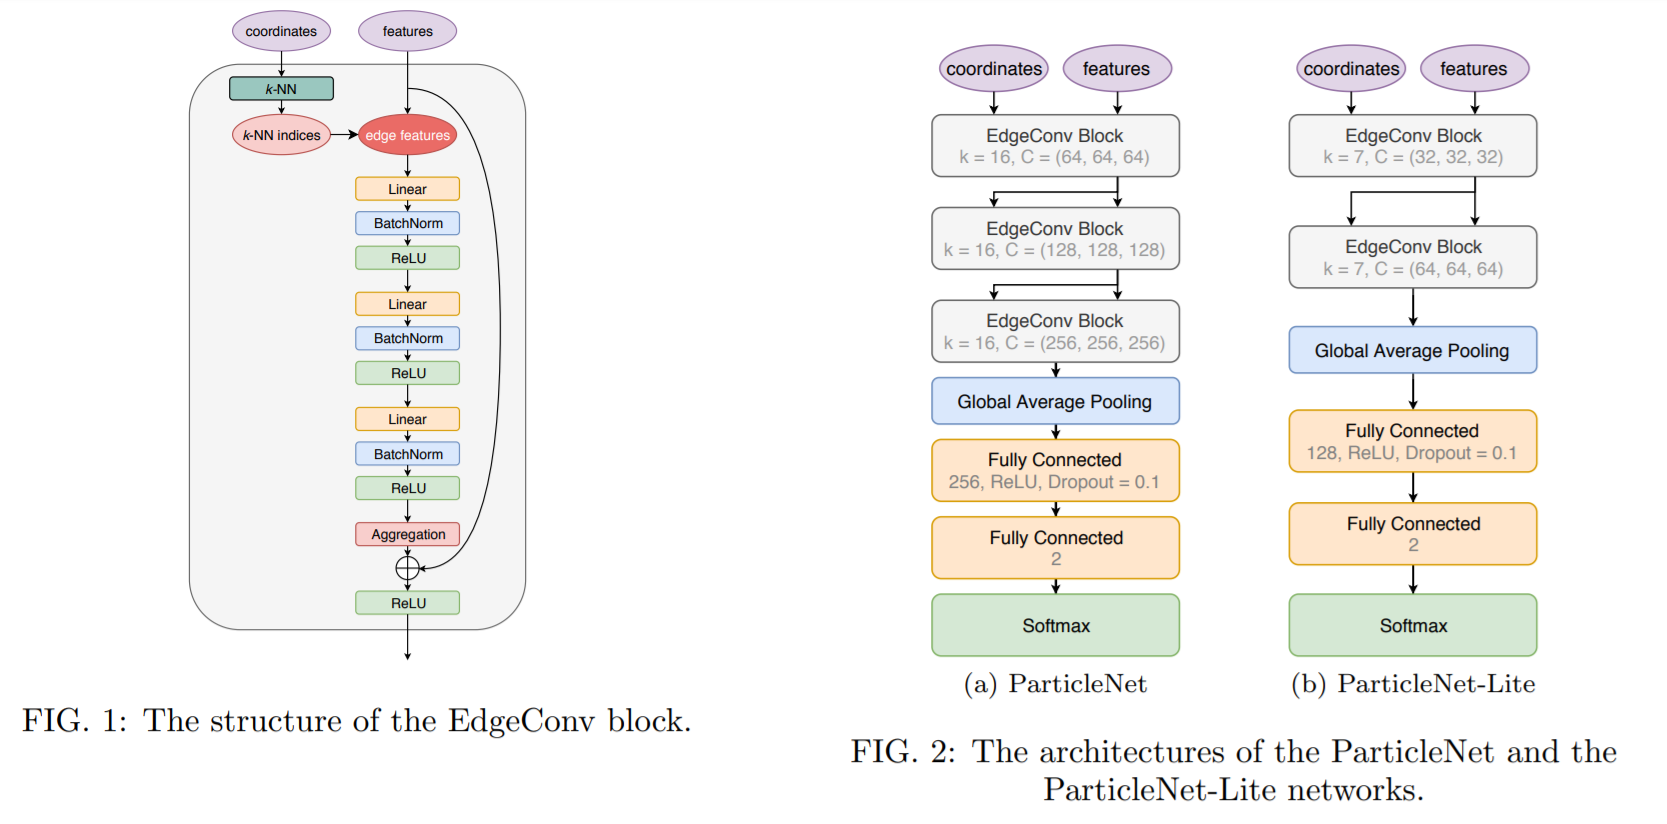

In [0]:
def edge_conv(points, features, num_points, K, channels, with_bn: bool = True, 
              activation='relu', pooling='average', name='edgeconv'):
    r"""
    Implements Edge Convolution

    Inputs
    ------
    points: (N, P, C_p)
    features: (N, P, C_0)

    Parameters
    ----------
    K: int 
        Number of neighbors
    in_channels: int 
        Number of input channels
    channels: tuple 
        Tuple of output channels
    pooling: str
        Pooling method ('max' or 'average')
    with_bn: bool
        With Batch Normalization, if not then we use bias on Conv layers

    Returns
    -------
        transformed points: (N, P, C_out), C_out = channels[-1]

    Warning
    -------
    This function assumes that the Data Format is Channel Last, do not change
    format in the DataSet class.
    """

    with tf.name_scope('edgeconv'):

        # Compute the K-nearest neighbors to each particle in the same jet (on eta-phi or latent space)
        D = batch_distance_matrix_general(points, points)  # Get the distance of all particle pairs: (N, P, P)
        _, indices = tf.nn.top_k(-D, k = K + 1, name='%s/topk' % (name))  # Take the particle indices which are closest to us: (N, P, K+1)
        indices = indices[:, :, 1:]  # Remove self from the list of nearest neigbors: (N, P, K)

        fts = features
        knn_fts = knn(num_points, K, indices, fts)  # Gives the filtered Feature Vectors: (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # My Features repeated K times: (N, P, K, C)

        # (My Feature, Neighbor - My Feature) for all (N, P, K): (N, P, K, 2*C)
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)
        x = knn_fts # We shall call this our X (input feature vector for the Edge Conv model)

        for idx, channel in enumerate(channels):
            # Features after expanding is of shape (N, P, K, 2*C) and the convolution gets applied
            # on a P * K sized image going from 2 * C input channels to the output channels
            x = tf.keras.layers.Conv2D(
                channel,
                kernel_size=(1, 1), 
                strides=1,
                data_format='channels_last', 
                use_bias = False if with_bn else True, 
                kernel_initializer='glorot_normal',
                name='%s/conv%d' % (name, idx)
            )(x)
            # Batch normalize and apply Activation
            if with_bn:
                x = tf.keras.layers.BatchNormalization(name='%s/bn%d' % (name, idx))(x)
            if activation:
                x = tf.keras.layers.Activation(activation, name='%s/act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # Shortcut - Important: It's a convolution to correct dimentions, not a straight addition
        # Features after expanding is of shape (N, P, 1, C_0) and the convolution gets applied
        # on a P * 1 sized image going to the output channels
        sc = tf.keras.layers.Conv2D(
            channels[-1],
            kernel_size = (1, 1), 
            strides = 1, 
            data_format = 'channels_last',
            use_bias = False if with_bn else True, 
            kernel_initializer = 'glorot_normal', 
            name='%s/sc_conv' % name
        )(tf.expand_dims(features, axis=2))

        # Batch normalize and apply Activation, output with Skip connection
        if with_bn:
            sc = tf.keras.layers.BatchNormalization(name='%s/sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)
        if activation:
            return tf.keras.layers.Activation(activation, name='%s/sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts

In [0]:
def _particle_net_base(points, features=None, mask=None, setting=None, name='particle_net'):
    r"""
    Parameters
    ----------
    points: tf.keras.layers.Input, (N, P, C_coord)
        keras input layer for the point
    features: tf.keras.layers.Input, (N, P, C_features), optional
        keras input layer for the features
    mask: tf.keras.layers.Input, (N, P, 1), optinal:
        keras input layer for the mask
    setting: _DotDict()
        stores some Hyper parameters in a free object
    name: str
        name of the model to be returned (prefix of all parts of this model)

    Notes
    -----
    These are the features included in each of the input facets:
    'points': ['part_etarel', 'part_phirel'],
    'features': ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel'],
    'mask': ['part_pt_log']

    Points exist on the Eta-phi plane, we can choose to augment the information
    with the log of energy and transverse momentum
    """

    with tf.name_scope(name):

        # If explicit features are not passed, then the features are the points
        if features is None:
            features = points

        # Makes a boolean mask out of the input mask, 1 if it's valid (in the mask), 999 if it's not.
        # Represents a padding particle or Transverse momentum is 1
        # TODO: Find out if an why Transverse Momentum = 1 needs to be checked.
        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # make valid positions to 1
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 999
        else:
            raise NotImplementedError('Implement an allow all mask')

        # CHANGES: fts = tf.squeeze(tf.keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)), axis=2)
        fts = tf.keras.layers.BatchNormalization(name='%s/fts_bn'%name)(features)

        # Extracting CONV Parameters (K, (C1, C2, C3)) from the settings we passed in
        for layer_idx, layer_param in enumerate(setting.conv_params):
            K, channels = layer_param
            # Masked out points get a (+999, +999) - coordinate shift on the 
            # eta-phi plane, after each layer
            pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts)
            # Now we repeat edge-conv over all layers starting with (Points, Features) and
            # then the next layers are (Previous Layer masked, Previous Layer)
            fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s/%s_%d' % (name, 'edge_conv', layer_idx))

        # Filter out the masked out particles to 0
        if mask is not None:
            fts = tf.multiply(fts, mask)

        # Output shape: (N, C) - Takes the average of all the particles in the jet
        pool = tf.reduce_mean(fts, axis=1)  

        # Extracting CONV Parameters (Units, Dropout) from the settings we passed in
        if setting.fc_params is not None:
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                # Add the Dense and Dropout layers
                x = tf.keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = tf.keras.layers.Dropout(drop_rate)(x)
            # Final Classification layer
            out = tf.keras.layers.Dense(setting.num_class, activation='softmax')(x)
            return out  # (N, num_classes)
        else:
            return pool

In [0]:
class _DotDict:
    pass

## Putting together the Final Models

In [0]:
def get_particle_net(num_classes, input_shapes, model_name='particlenet-lite'):
    r"""
    ParticleNet-Lite model

    Parameters
    ----------
    num_classes: int
        Number of output classes
    input_shapes: dict
        The shapes of each input (`points`, `features`, `mask`)

    Example
    -------
    get_particle_net_lite(2, {'points': (100, 2), 'features': (100, 4), 'mask': (100, 1)})
    """
    assert model_name in ['particlenet-lite', 'particlenet-full']

    # Creates the Setting dictionary for configuring up the Network 
    setting = _DotDict()
    setting.num_class = num_classes
    if model_name == 'particlenet-lite':
        setting.conv_params = [
            (12, (32, 32, 32)),
            (12, (64, 64, 64)),
        ] # conv_params: list of tuple in the format (K, (C1, C2, C3))
    elif model_name == 'particlenet-full':
        setting.conv_params = [
            (16, (64, 64, 64)),
            (16, (128, 128, 128)),
            (16, (256, 256, 256)),
        ]
    else:
        raise NotImplementedError('Unknown Model Name')

    setting.conv_pooling = 'average' # conv_pooling: 'average' or 'max'
    if model_name == 'particlenet-lite':
        setting.fc_params = [(128, 0.1)] # fc_params: list of tuples in the format (C, drop_rate)
    elif model_name == 'particlenet-full':
        setting.fc_params = [(256, 0.1)]
    else:
        raise NotImplementedError('Unknown Model Name')

    setting.num_points = input_shapes['points'][0]

    # Make the Keras input layers and send them and the settings to the net generator
    points = tf.keras.Input(name='points', shape=input_shapes['points'])
    features = tf.keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = tf.keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _particle_net_base(points, features, mask, setting, name='particle_net')

    # Returns the final Keras model
    return tf.keras.Model(inputs=[points, features, mask], outputs=outputs, name='ParticleNet')

# Running the Model

## Setup for the Model

In [0]:
model_name = 'particlenet-lite'

num_classes = train_dataset.y.shape[1]
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
model = get_particle_net(num_classes, input_shapes, model_name=model_name)

In [0]:
batch_size = 1024 if 'lite' in model_name else 384
epochs = 30

def lr_schedule(epoch):
    return 1e-3 if epoch <= 10 else 1e-4 if epoch <= 20 else 1e-5

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

In [0]:
tf.keras.utils.plot_model(model, 'model.png')

## Training the Model

In [0]:
train_dataset.shuffle()
model.fit(
    train_dataset.X, train_dataset.y,
    batch_size=batch_size,
    epochs=10,
    validation_data=(val_dataset.X, val_dataset.y),
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(PROJECT_DIR, 'checkpoints/best.h5'), 
            monitor='val_loss', verbose=True, save_best_only=True,
            save_weights_only=False, mode='auto', save_freq='epoch'
        ),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule),
        tf.keras.callbacks.ProgbarLogger('steps'),
        tf.keras.callbacks.TensorBoard('logs/', histogram_freq=1)
    ]
)

In [0]:
model.save(os.path.join(PROJECT_DIR, 'model-full.h5'))

# Performance Evaluation

## Training Stats Plot

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(model.history.history['loss'])
ax[0].plot(model.history.history['val_loss'])
ax[0].legend(['Training', 'Validation'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_title('Loss')


ax[1].plot(model.history.history['accuracy'])
ax[1].plot(model.history.history['val_accuracy'])
ax[1].legend(['Training', 'Validation'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Accuracy')

fig.suptitle('Training Curves')
plt.show()

## Running TensorBoard

In [0]:
import shutil
shutil.rmtree(os.path.join(PROJECT_DIR, 'logs'))
shutil.copytree('logs', os.path.join(PROJECT_DIR, 'logs'))
os.listdir(os.path.join(PROJECT_DIR, 'logs'))

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
%tensorboard --logdir logs

# Visualizing the Network

## Who is in my Neighborhood

In [0]:
topk_layers = [ layer.output[1] for layer in model.layers if 'topk' in layer.name ]
aux_model = tf.keras.Model(inputs=model.inputs, outputs=model.outputs + topk_layers)

In [0]:
# Plotting part
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for j, axis in enumerate(ax):

    event_id = np.random.randint(len(val_dataset['points']))
    trace_id = np.random.randint(20)

    event = {
        'points': train_dataset.X['points'][event_id : event_id+1], 
        'features': train_dataset.X['features'][event_id : event_id+1], 
        'mask': train_dataset.X['mask'][event_id : event_id+1]
    }
    knn_group = np.concatenate(aux_model.predict(event)[1:], axis=0)
    mask = tf.cast(tf.not_equal(event['mask'], 0), dtype='float32') 
    n_particles = int(tf.reduce_sum(mask).numpy())

    print('Class of Sample', j, ':', np.argmax(model.predict(event)))

    for i in range(len(axis)):
        neighborhood = knn_group[i, trace_id]
        colors = ['k' if particle not in neighborhood else 'r' if particle != trace_id else 'g' for particle in range(n_particles)]
        sizes = [3 if particle not in neighborhood else 20 if particle != trace_id else 40 for particle in range(n_particles)]
        axis[i].scatter(
            event['points'][0, :n_particles, 0], 
            event['points'][0, :n_particles, 1], 
            color=colors, s=sizes)
        axis[i].set_title('Sample %d - Layer %d'%(j + 1, i))
fig.suptitle('Neigborhood Plots')
plt.show()

In [0]:
mask = tf.cast(tf.not_equal(event['mask'], 0), dtype='float32')  # make valid positions to 1
n_particles = int(tf.reduce_sum(mask).numpy())
print('Number of Particles:', n_particles)
coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 999
pts = tf.add(coord_shift, event['points'])[:, 0:n_particles, :]

D = batch_distance_matrix_general(pts, pts).numpy()  # Get the distance of all particle pairs: (N, P, P)
sns.heatmap(D[0, :, :])
plt.show()
# _, indices = tf.nn.top_k(-D, k = K + 1, name='%s/topk' % (name))  # Take the particle indices which are closest to us: (N, P, K+1)


# Going Further

## Ideas to Work with

* Hierarchical loss for multi-class classification
* Angle convolutions and Neighbor problems
* Point Splitting and Ensembling
* Add physics guided, any inference that is forced
* Multi-top event (counting)

Inspiration Research Papers:
* https://arxiv.org/pdf/1810.02303.pdf - Multi-directional Geodesic Neural Networks via Equivariant Convolution
